# Custom OCR - text recognition

# Importing the libraries

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import imutils
from google.colab.patches import cv2_imshow

# Loading the neural network

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
network = load_model('/content/drive/MyDrive/OCR using python/Models/network')
network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

# Loading the test image

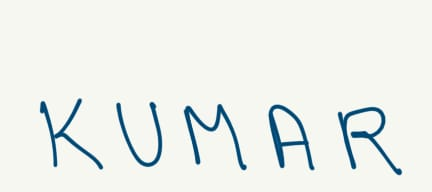

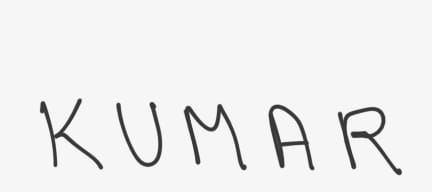

In [ ]:
img = cv2.imread('/content/drive/MyDrive/OCR using python/Images/kumar3.jpg')
cv2_imshow(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

# Pre-processing the image

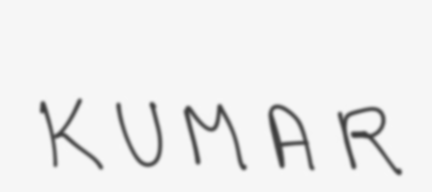

In [ ]:
#removing noise (more blur less noise)
blur = cv2.GaussianBlur(gray, (7,7), 0)A
cv2_imshow(blur)

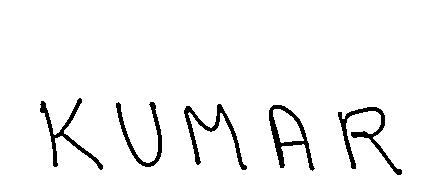

In [ ]:
#thresholding to highlight the text
adaptive = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 9)
cv2_imshow(adaptive)

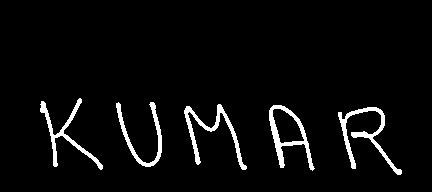

In [ ]:
#inverting the colour so that it matches the dataset format(black background white text)
invertion = 255 - adaptive
cv2_imshow(invertion)


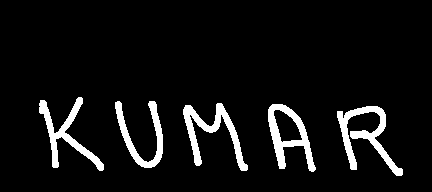

In [ ]:
#dilating the image to thicken it so that it looks clean and later can be used for edge detection
dilation1 = cv2.dilate(invertion, np.ones((3,3)))
cv2_imshow(dilation1)

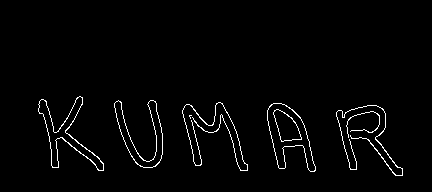

In [ ]:
#detecting the edges using canny
edges = cv2.Canny(dilation1, 40, 150)
cv2_imshow(edges)

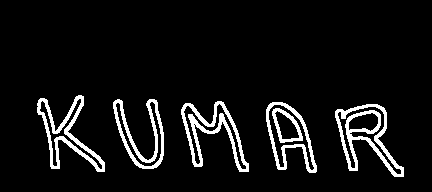

In [ ]:
#dilation again to get better outer edge for detection
dilation2 = cv2.dilate(edges, np.ones((3,3)))
cv2_imshow(dilation2)

# Contour detection

In [ ]:
#a combined process for image preprocessing same as above few steps
def preprocess_img(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(gray, (3, 3), 7)
  edges = cv2.Canny(blur, 40, 150)
  dilation = cv2.dilate(edges, np.ones((3,3)))
  return gray, dilation

In [ ]:
#contouring is to isolate and identify the regions containing text, which are then extracted and analyzed to recognize the characters.
def find_contours(img):
  conts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  conts = imutils.grab_contours(conts)
  conts = sort_contours(conts, method = 'left-to-right')[0]
  return conts

In [ ]:
conts = find_contours(dilation2.copy())

In [ ]:
conts

(array([[[ 78,  95]],
 
        [[ 77,  96]],
 
        [[ 76,  96]],
 
        [[ 75,  97]],
 
        [[ 75,  98]],
 
        [[ 74,  99]],
 
        [[ 74, 101]],
 
        [[ 73, 102]],
 
        [[ 73, 103]],
 
        [[ 72, 104]],
 
        [[ 72, 105]],
 
        [[ 71, 106]],
 
        [[ 71, 107]],
 
        [[ 70, 108]],
 
        [[ 70, 109]],
 
        [[ 69, 110]],
 
        [[ 69, 111]],
 
        [[ 68, 112]],
 
        [[ 68, 113]],
 
        [[ 67, 114]],
 
        [[ 67, 115]],
 
        [[ 65, 117]],
 
        [[ 65, 118]],
 
        [[ 63, 120]],
 
        [[ 63, 121]],
 
        [[ 60, 124]],
 
        [[ 60, 125]],
 
        [[ 58, 127]],
 
        [[ 58, 128]],
 
        [[ 55, 131]],
 
        [[ 54, 130]],
 
        [[ 54, 125]],
 
        [[ 53, 124]],
 
        [[ 53, 121]],
 
        [[ 52, 120]],
 
        [[ 52, 117]],
 
        [[ 51, 116]],
 
        [[ 51, 114]],
 
        [[ 50, 113]],
 
        [[ 50, 110]],
 
        [[ 49, 109]],
 
        [[ 49, 1

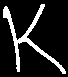

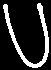

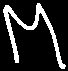

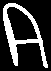

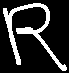

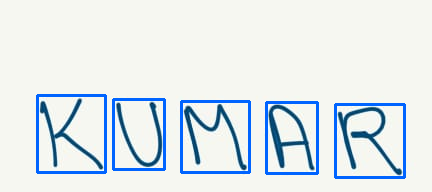

In [ ]:
#selecting and cropping out the text separately and displaying it.
#drawing bounding box around text with the help of their detected dimensions.
min_w, max_w = 3, 160
min_h, max_h = 12, 140
img_copy = img.copy()
for c in conts:
  #print(c)
  (x, y, w, h) = cv2.boundingRect(c)
  #print(x, y, w, h)
  if (w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
    roi = gray[y:y+h, x:x+w]
    #cv2_imshow(roi)
    thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    cv2_imshow(thresh)
    cv2.rectangle(img_copy, (x, y), (x + w, y + h), (255, 100, 0), 2)
cv2_imshow(img_copy)

# Processing the detected characters

## ROI extraction


In [ ]:
#extracting only required region of interest
def extract_roi(img):
  roi = img[y:y + h, x:x + w]
  return roi

## Thresholding

In [ ]:

def thresholding(img):
  thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
  return thresh

## Resizing

In [ ]:
#resizing to match it with dataset, using imutils to keep the proportion of image.
#copymakeborder here fills the image by padding to make it look accurate and to be
#able to resize
def resize_img(img, w, h):
  if w > h:
    resized = imutils.resize(img, width = 28)
  else:
    resized = imutils.resize(img, height = 28)

  (h, w) = resized.shape
  dX = int(max(0, 28 - w) / 2.0)
  dY = int(max(0, 28 - h) / 2.0)

  filled = cv2.copyMakeBorder(resized, top=dY, bottom=dY, right=dX, left=dX, borderType=cv2.BORDER_CONSTANT, value = (0,0,0))
  filled = cv2.resize(filled, (28,28))
  return filled

In [ ]:
(x, y, w, h) = cv2.boundingRect(conts[5])
print(x, y, w, h)
test_img = thresholding(gray[y:y+h, x:x+w])
cv2_imshow(test_img)
(h, w) = test_img.shape
print(h, w)
test_img2 = resize_img(test_img, w, h)
cv2_imshow(test_img2)
print(test_img2.shape)

IndexError: tuple index out of range

In [ ]:
cv2_imshow(cv2.resize(test_img, (28,28)))

NameError: name 'test_img' is not defined

## Normalization

In [ ]:
#normalization helps standardize the input data and ensures that the model can learn more effectively by avoiding issues such as
#vanishing or exploding gradients during training
#removing the distortions
def normalization(img):
  img = img.astype('float32') / 255.0
  img = np.expand_dims(img, axis = -1)
  return img

In [ ]:
test_img2.shape, normalization(test_img2).shape

NameError: name 'test_img2' is not defined

## Processing the detections

In [ ]:
characters = []

In [ ]:
#getting the required region of text, thresholding it , finally resizing and displaying it.
#later normalizing it to remove distortions and adding it characters with the dimensions of the image.
def process_box(gray, x, y, w, h):
  roi = extract_roi(gray)
  thresh = thresholding(roi)
  (h, w) = thresh.shape
  resized = resize_img(thresh, w, h)
  cv2_imshow(resized)
  normalized = normalization(resized)
  characters.append((normalized, (x, y, w, h)))

print(h,w)

73 69


In [ ]:
for c in conts:
  #print(c)
  (x, y, w, h) = cv2.boundingRect(c)
  if (w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
    process_box(gray, x, y, w, h)

In [ ]:
characters[0]

(array([[[0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ]],
 
        [[0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
        

In [ ]:
#getting the dimensions of textboxes for each text.
boxes = [box[1] for box in characters]
boxes

[(37, 95, 68, 77),
 (113, 99, 51, 70),
 (181, 101, 68, 71),
 (266, 102, 51, 71),
 (335, 104, 69, 73)]

In [ ]:
pixels = np.array([pixel[0] for pixel in characters], dtype = 'float32')

In [ ]:
#pixels regarding all detected texts
pixels[0]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.3529412 ],
        

# Recognition of characters

In [ ]:
digits = '0123456789'
letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
characters_list = digits + letters
characters_list = [l for l in characters_list]

In [ ]:
print(characters_list)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [ ]:
pixels.shape

(5, 28, 28, 1)

In [ ]:
pixels.shape

(5, 28, 28, 1)

In [ ]:
predictions = network.predict(pixels)

1/1 [==============================] - 2s 2s/step


In [ ]:
predictions

array([[0.00000000e+00, 1.61650445e-31, 5.16362316e-25, 0.00000000e+00,
        9.51588809e-25, 5.98806768e-29, 4.94446080e-20, 3.70476729e-29,
        8.12301907e-26, 0.00000000e+00, 3.02737462e-24, 2.03045682e-20,
        3.97057075e-23, 4.85065244e-22, 2.92734508e-24, 6.85946136e-37,
        4.87041303e-24, 4.41770813e-14, 0.00000000e+00, 3.02049110e-22,
        1.00000000e+00, 2.77271123e-10, 5.82611693e-25, 7.46607599e-20,
        5.97979345e-25, 2.76641767e-19, 1.36600975e-29, 2.65695024e-18,
        7.65679062e-19, 1.33515622e-13, 7.20162698e-17, 8.83035906e-38,
        5.62708517e-13, 8.12000532e-13, 3.28578073e-14, 6.00716396e-24],
       [4.83996200e-06, 6.70638037e-05, 1.14771534e-08, 2.75880967e-11,
        3.66794062e-09, 2.45664307e-08, 2.40404585e-08, 1.31898518e-12,
        1.64525922e-08, 3.71446606e-15, 2.45492137e-14, 1.26973692e-11,
        2.53785188e-08, 2.51157053e-05, 6.30476851e-16, 1.12504364e-24,
        2.47259777e-08, 6.90823132e-09, 5.53311766e-17, 5.76796

In [ ]:
predictions.shape

(5, 36)

In [ ]:
boxes

[(37, 95, 68, 77),
 (113, 99, 51, 70),
 (181, 101, 68, 71),
 (266, 102, 51, 71),
 (335, 104, 69, 73)]

K  ->  100.0
U  ->  99.91554021835327
M  ->  99.99508857727051
A  ->  99.9868392944336
R  ->  99.95810389518738


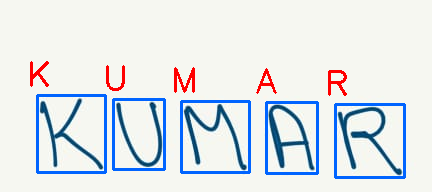

In [ ]:
#detecting character one by one and gessing and displaying the result.
img_copy = img.copy()
for (prediction, (x, y, w, h)) in zip(predictions, boxes):
  i = np.argmax(prediction) #getting indexes with max values
  #print(i)
  probability = prediction[i]
  #print(probability)
  character = characters_list[i]
  #print(character)

  cv2.rectangle(img_copy, (x, y), (x + w, y + h), (255,100,0), 2)
  cv2.putText(img_copy, character, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0,0,255), 2)
  print(character, ' -> ', probability * 100)

cv2_imshow(img_copy)

Again detecting text, where we are trying to draw bounding boxes a bit away from boder of text to try to get better probability.


In [ ]:
# #bounding box will not be close to border of letter to get better results.
# def extract_roi(img, margin=2):
#   roi = img[y - margin:y + h, x - margin:x + w + margin]
#   return roi

In [ ]:
conts = find_contours(dilation2.copy())
characters = []
for c in conts:
  (x, y, w, h) = cv2.boundingRect(c)
  if (w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
    process_box(gray, x, y, w, h)

In [ ]:
boxes = [b[1] for b in characters]
pixels = np.array([p[0] for p in characters], dtype='float32')
predictions = network.predict(pixels)

5/5 [==============================] - 0s 3ms/step


1  ->  98.796147108078
1  ->  44.46117281913757
9  ->  42.874693870544434
T  ->  98.19433093070984
B  ->  97.67518043518066
J  ->  72.02197313308716
S  ->  39.50703740119934
L  ->  99.99617338180542
T  ->  99.14516806602478
H  ->  99.99949932098389
R  ->  99.37652349472046
U  ->  96.91325426101685
A  ->  99.99661445617676
0  ->  76.4924168586731
A  ->  99.9998688697815
E  ->  99.89156723022461
0  ->  86.813884973526
H  ->  93.61598491668701
Z  ->  92.36197471618652
U  ->  65.58997631072998
W  ->  99.47998523712158
R  ->  99.99912977218628
P  ->  98.55711460113525
Y  ->  98.50354194641113
S  ->  43.621280789375305
T  ->  99.9599277973175
W  ->  90.43954610824585
N  ->  99.71016049385071
J  ->  85.6524109840393
D  ->  49.584513902664185
O  ->  52.39481329917908
Y  ->  94.16242837905884
F  ->  76.5002429485321
6  ->  45.448583364486694
N  ->  97.95145988464355
0  ->  84.66655611991882
V  ->  98.1747567653656
K  ->  90.09975790977478
H  ->  95.60917019844055
C  ->  35.20061671733856
L  -> 

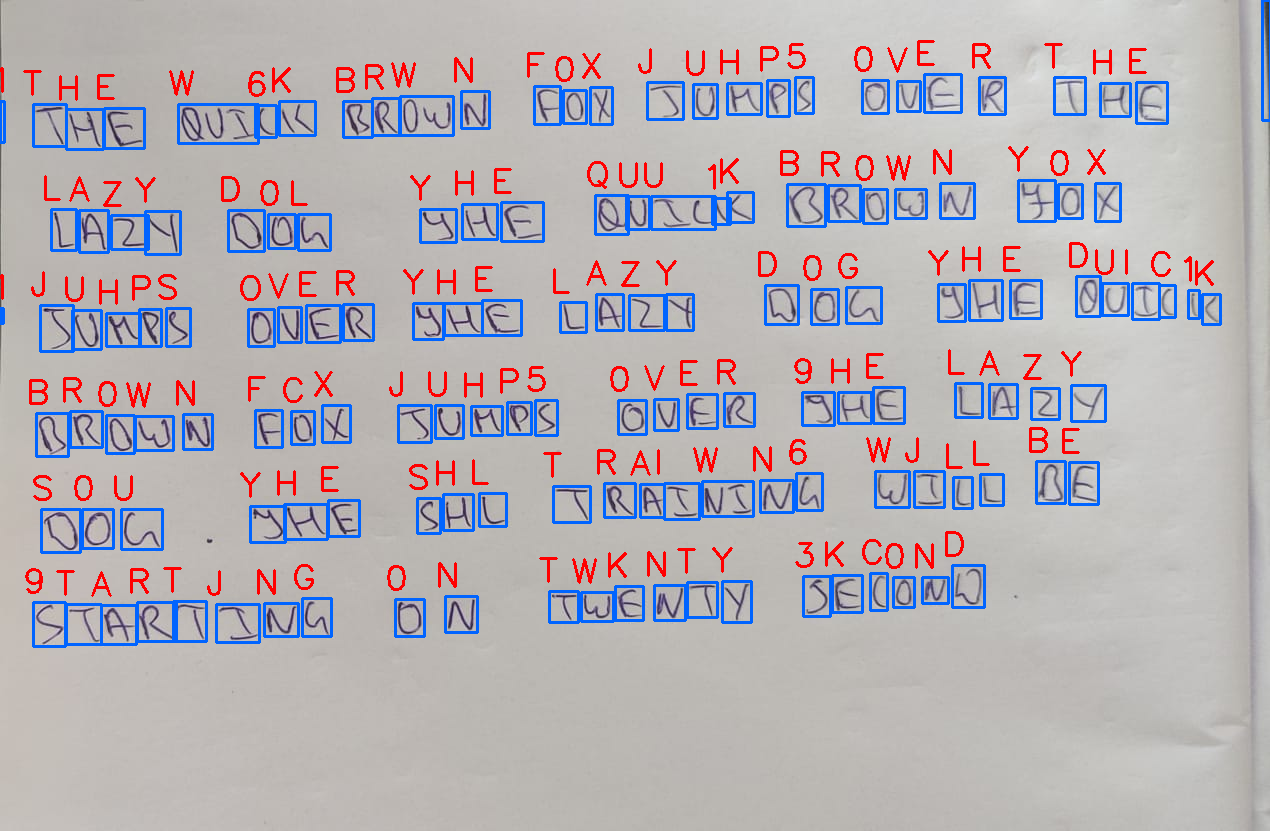

In [ ]:
img_copy = img.copy()
for (prediction, (x, y, w, h)) in zip(predictions, boxes):
  i = np.argmax(prediction)
  probability = prediction[i]
  character = characters_list[i]

  cv2.rectangle(img_copy, (x, y), (x + w, y + h), (255,100,0), 2)
  cv2.putText(img_copy, character, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0,0,255), 2)
  print(character, ' -> ', probability * 100)

cv2_imshow(img_copy)

got better result of some character by extract_roi method

# Other tests

implementing functions for intial preprocessing steps done for avoiding repetition of code

In [ ]:
def preprocess_img(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(gray, (7, 7), 0)
  edges = cv2.Canny(blur, 40, 150)
  dilation = cv2.dilate(edges, np.ones((3,3)))
  return gray, dilation

In [ ]:
def prediction(predictions, characters_list):
  i = np.argmax(predictions)
  probability = predictions[i]
  character = characters_list[i]
  return i, probability, character

In [ ]:
def draw_img(img_cp, character):
  cv2.rectangle(img_cp, (x, y), (x + w, y + h), (255, 100, 0), 2)
  cv2.putText(img_cp, character, (x - 10, y - 10),cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 0, 255), 2)

## Problems with 0 and O, 1 an I, 5 and S

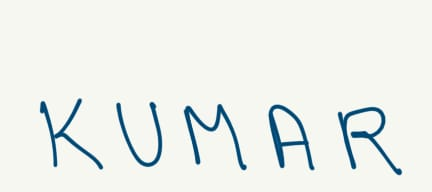

In [ ]:
img = cv2.imread('/content/drive/MyDrive/OCR using python/Images/kumar3.jpg')
cv2_imshow(img)

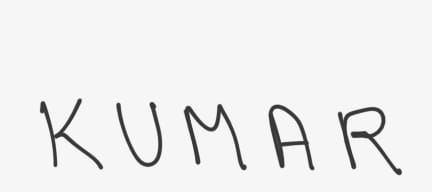

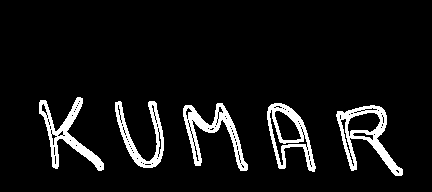

In [ ]:
gray, processed_img = preprocess_img(img)
cv2_imshow(gray)
cv2_imshow(processed_img)

In [ ]:
conts = find_contours(processed_img.copy())
characters = []
for c in conts:
  (x, y, w, h) = cv2.boundingRect(c)
  if (w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
    process_box(gray, x, y, w, h)

boxes = [b[1] for b in characters]
pixels = np.array([p[0] for p in characters], dtype="float32")
predictions = network.predict(pixels)

1/1 [==============================] - 0s 19ms/step


In [ ]:
digits_2 = '0123456789'
letters_2 = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
characters_list_2 = digits_2 + letters_2
characters_list_2 = [l for l in characters_list_2]

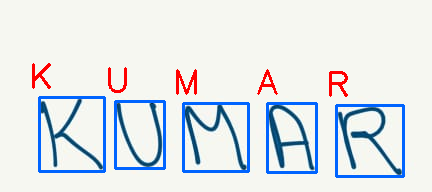

In [ ]:
img_cp = img.copy()
for (pred, (x, y, w, h)) in zip(predictions, boxes):
  i, probability, character = prediction(pred, characters_list_2)
  draw_img(img_cp, character)
cv2_imshow(img_cp)

## Problems with undetected texts

In [ ]:
img = cv2.imread('/content/drive/MyDrive/OCR using python/Images/para.jpg')
cv2_imshow(img)

In [ ]:
gray, processed_img = preprocess_img(img)
cv2_imshow(gray)
cv2_imshow(processed_img)

In [ ]:
conts = find_contours(processed_img.copy()) # RETR_EXTERNAL
img_cp = img.copy()
for c in conts:
  (x, y, w, h) = cv2.boundingRect(c)
  #if (w >= l_min and w <= l_max) and (h >= a_min and h <= a_max):
  roi = gray[y:y + h, x:x + w]
  thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
  cv2.rectangle(img_cp, (x, y), (x + w, y + h), (255, 100, 0), 2)
cv2_imshow(img_cp)

In [ ]:
height, width = img.shape[:2]
print(height, width)

In [ ]:
contours_size = sorted(conts, key=cv2.contourArea, reverse=True)
contours_size

In [ ]:
# cutoff value represents the margin or boundary around the detected text region.
#code then uses the cut_off value to define a region of interest within the
#bounding rectangle. It selects a subregion of the original image (img) by cropping
#it with an additional margin on each side (cut_off) using array slicing:

'''When the cutoff value is increased, the margin around the detected text
region becomes larger. This means more pixels will be removed from the edges
of the bounding rectangle when extracting the subregion, resulting in a smaller
cropped region.

Conversely, when the cutoff value is decreased, the margin becomes smaller,
allowing more of the pixels from the edges of the bounding rectangle to be
included in the cropped region. This leads to a larger cropped region.'''

for c in contours_size:
  (x, y, w, h) = cv2.boundingRect(c)

  if (w >= (width / 2)) and (h >= height / 2):
    cut_off = 20
    cut_img = img[y+cut_off:y + h - cut_off, x+cut_off:x + w - cut_off]
    cv2_imshow(cut_img)

In [ ]:
gray, processed_img = preprocess_img(cut_img)
cv2_imshow(processed_img)

In [ ]:
conts = find_contours(processed_img.copy())
characters = []
for c in conts:
  (x, y, w, h) = cv2.boundingRect(c)
  if (w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
    process_box(gray, x, y, w, h)

boxes = [b[1] for b in characters]
pixels = np.array([p[0] for p in characters], dtype="float32")
predictions = network.predict(pixels)

img_cp = cut_img.copy()
for (pred, (x, y, w, h)) in zip(predictions, boxes):
  i, probability, character = prediction(pred, characters_list_2)
  draw_img(img_cp, character)
cv2_imshow(img_cp)